In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/My papers/earthquake_gen/dataset_embedding")

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

In [ ]:
class CFMDataset(Dataset):
    """
    Dataset for Conditional Flow Matching training.

    Loads pre-computed embeddings (conditions) and images (targets).
    Images are already normalized as log10(Mag + 1e-8).

    Usage:
        # From .pt file
        dataset = CFMDataset.from_pt("./data/cfm_dataset/cfm_dataset.pt", target_size=64)

        # Get a sample
        embedding, image = dataset[0]
        # embedding: [embedding_dim] - condition for flow matching
        # image: [C, H, W] - target image (log-normalized, resized to target_size)
    """
    def __init__(self, embeddings: torch.Tensor, images: torch.Tensor, target_size: int = 64, indices=None):
        """
        Args:
            embeddings: [N, embedding_dim]
            images: [N, C, H, W]
            target_size: resize images to (target_size, target_size)
            indices: optional subset indices
        """
        self.embeddings = embeddings
        self.target_size = target_size

        # Resize images to target_size x target_size
        if images.shape[-1] != target_size or images.shape[-2] != target_size:
            self.images = F.interpolate(
                images,
                size=(target_size, target_size),
                mode='bilinear',
                align_corners=False
            )
        else:
            self.images = images

        self.indices = indices if indices is not None else np.arange(embeddings.shape[0])
        self.x_mean = None
        self.x_std = None

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        if self.x_mean is not None and self.x_std is not None:
            return (self.embeddings[real_idx] - self.x_mean) / (self.x_std + 1e-8), self.images[real_idx]
        else:
            return self.embeddings[real_idx], self.images[real_idx]

    def fit_normalizer(self, indices):
        idx = torch.as_tensor(indices, dtype=torch.long)

        x = self.embeddings.index_select(0, idx)

        self.x_mean = x.mean(dim=0)
        self.x_std = x.std(dim=0, unbiased=False)
        self.x_std = torch.clamp(self.x_std, min=1e-8)

    @classmethod
    def from_pt(cls, path: str, target_size: int = 64, split: str = None):
        """
        Load from PyTorch .pt file.

        Args:
            path: path to .pt file
            target_size: resize images to (target_size, target_size)
            split: "train", "val", or None (all data)
        """
        data = torch.load(path, weights_only=False)
        embeddings = data["embeddings"]
        images = data["images"]

        if split == "train":
            indices = data["train_indices"]
        elif split == "val":
            indices = data["val_indices"]
        else:
            indices = None

        return cls(embeddings, images, target_size, indices)


# Target size for all images
target_size = 64

dataset = CFMDataset.from_pt("cfm_dataset.pt", target_size=target_size)
print(f"Dataset loaded: {len(dataset)} samples")
print(f"  - Embeddings shape: {dataset.embeddings.shape}")
print(f"  - Images shape: {dataset.images.shape}")

Dataset loaded: 1855 samples
  - Embeddings shape: torch.Size([1855, 3])
  - Images shape: torch.Size([1855, 1, 64, 64])


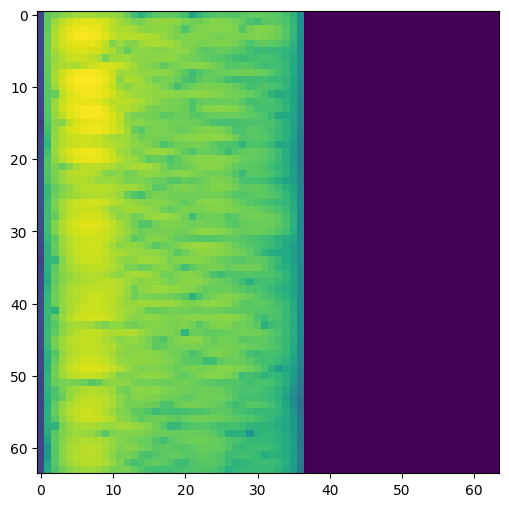

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))

ax.imshow(dataset[0][1][0])

In [ ]:
n = len(dataset)
g = torch.Generator().manual_seed(42)
perm = torch.randperm(n, generator=g).tolist()

train_ratio = 0.8
train_end = int(train_ratio * n)
train_idx = perm[:train_end]
test_idx = perm[train_end:]

dataset.fit_normalizer(train_idx)

train_ds = Subset(dataset, train_idx)
test_ds = Subset(dataset, test_idx)

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x

class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x

class Flatten(nn.Module):
    def __init__(self, kernel):
        super().__init__()
        self.flatten = nn.AvgPool2d(
            kernel_size=kernel
        )
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.gelu(x)
        return x

class Unflatten(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel: int, stride: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel,
            stride=stride,
            padding=0
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = DownConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = UpConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super().__init__()
        self.gelu = nn.GELU()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_channels, out_channels))
        for _ in range(num_layers):
            self.layers.append(nn.Linear(out_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
            x = self.gelu(x)
        return x

class ResnetBlockAdaGN(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int, groups: int = 8):
        super().__init__()

        self.norm1 = nn.GroupNorm(groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, 2 * out_channels),
        )

        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, emb):
        h = x

        h = self.norm1(h)
        h = self.act1(h)
        h = self.conv1(h)

        emb_out = self.emb_layers(emb)

        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out.unsqueeze(-1)

        scale, shift = torch.chunk(emb_out, 2, dim=1)

        h = self.norm2(h)
        h = h * (1 + scale) + shift
        h = self.act2(h)
        h = self.conv2(h)

        return h + self.shortcut(x)

In [ ]:
class ScalableAdaGNUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        x_features: int,
        base_channels: int = 64,
        channel_mults: tuple = (1, 2, 4, 8),
        time_emb_dim: int = 256
    ):
        super().__init__()

        self.channels = [base_channels * m for m in channel_mults]
        self.x_features = x_features
        self.time_emb_dim = time_emb_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        self.class_mlp = nn.Sequential(
            nn.Linear(x_features, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.inc = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        in_ch = base_channels
        for out_ch in self.channels:
            self.downs.append(nn.ModuleList([
                ResnetBlockAdaGN(in_ch, out_ch, time_emb_dim),
                DownConv(out_ch, out_ch)
            ]))
            in_ch = out_ch

        self.mid_block1 = ResnetBlockAdaGN(in_ch, in_ch, time_emb_dim)
        self.mid_block2 = ResnetBlockAdaGN(in_ch, in_ch, time_emb_dim)

        reversed_channels = list(reversed(self.channels))
        for i, skip_ch in enumerate(reversed_channels):
            out_ch = reversed_channels[i+1] if i < len(reversed_channels)-1 else base_channels

            self.ups.append(nn.ModuleList([
                UpConv(in_ch, in_ch),
                ResnetBlockAdaGN(in_ch + skip_ch, out_ch, time_emb_dim)
            ]))
            in_ch = out_ch

        self.outc = nn.Conv2d(base_channels, 1, 3, padding=1)
        # self.register_buffer("uncond", torch.zeros(x_features))
        self.uncond = nn.Parameter(torch.zeros(x_features))

    def forward(self, x, c, t, mask=None):
        t = t.view(-1, 1).float()

        if mask is not None:
            c_in = c.clone()
            c_in[~mask.bool()] = self.uncond
        else:
            c_in = c

        emb = self.time_mlp(t) + self.class_mlp(c_in)
        x1 = self.inc(x)
        skips = [x1]
        h = x1

        for res_block, down_sample in self.downs[:-1]:
            h = res_block(h, emb)
            skips.append(h)
            h = down_sample(h)
        last_res, last_down = self.downs[-1]
        h = last_res(h, emb)
        skips.append(h)
        h = last_down(h)
        h = self.mid_block1(h, emb)
        h = self.mid_block2(h, emb)
        for up_sample, res_block in self.ups:
            h = up_sample(h)
            skip = skips.pop()
            if h.shape[2:] != skip.shape[2:]:
                h = F.interpolate(h, size=skip.shape[2:], mode='bilinear', align_corners=False)
            h = torch.cat([h, skip], dim=1)
            h = res_block(h, emb)

        return self.outc(h)

In [ ]:
def class_fm_forward(
    unet: ScalableAdaGNUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    unet.train()
    x0 = torch.randn_like(x_1, device=x_1.device)
    t = torch.rand(x_1.shape[0], device=x_1.device)
    t_ = t.view(-1,1,1,1)
    x_t = (1 - t_) * x0 + t_ * x_1
    mask = torch.rand(x_1.shape[0], device=x_1.device)
    mask = mask > p_uncond

    v_t_hat = unet(x_t, c, t, mask)
    loss = F.mse_loss(v_t_hat, x_1 - x0)
    return loss

In [ ]:
@torch.inference_mode()
def class_fm_sample(
    unet: ScalableAdaGNUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    unet.eval()
    caches = []
    device = next(unet.parameters()).device
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    N = c.shape[0]
    x_t = torch.randn((c.shape[0], 1, *img_wh), device=device, generator=g)

    mask_cond = torch.ones((N,), device=device, dtype=torch.bool)
    mask_uncond = torch.zeros((N,), device=device, dtype=torch.bool)

    ts = torch.linspace(0, 1, num_ts, device=device)
    for i in range(num_ts - 1):
        s = ts[i]
        t = torch.full((x_t.shape[0],), s, device=device)
        # u_cond = unet(x_t, c, t, mask_cond)
        # u_uncond = unet(x_t, c, t, mask_uncond)
        x_in = torch.cat([x_t, x_t])      # [2N, C, H, W]
        c_in = torch.cat([c, c])          # [2N, Feat]
        t_in = torch.cat([t, t])          # [2N]
        mask_in = torch.cat([mask_cond, mask_uncond]) # [2N]

        noise_pred = unet(x_in, c_in, t_in, mask_in)

        u_cond, u_uncond = noise_pred.chunk(2)

        u = u_uncond + guidance_scale * (u_cond - u_uncond)
        x_t += (ts[i+1] - ts[i]) * u
        caches.append(x_t.clone())
    return x_t, torch.stack(caches, dim=1)

In [ ]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ScalableAdaGNUNet,
        num_ts: int = 300,
        p_uncond: float = 0.05,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [ ]:
device = "cuda"
hidden_dim = 128
batch_size = 256
num_epochs = 200
learning_rate = 1e-3
x_feature_num = dataset.embeddings.shape[-1]
channel_mults = (1, 2, 4, 8, 16)
time_emb_dim = 128
target_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

unet = ScalableAdaGNUNet(1, x_feature_num, hidden_dim, channel_mults, time_emb_dim).to(device)
model = ClassConditionalFM(unet).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

total_steps = num_epochs * len(train_loader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

checkpoint_dir = "checkpoints_Jan19"
os.makedirs(checkpoint_dir, exist_ok=True)
best_val = float("inf")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for i, (x, y) in enumerate(tqdm(train_loader)):
        images = y.to(device)
        c = x.to(device)
        loss = model(images, c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            loss = model(y.to(device), x.to(device))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val:
        best_val = avg_val_loss
        savepath = os.path.join(checkpoint_dir, "best.pt")
        torch.save(model.state_dict(), savepath)

    print(f"Epoch {epoch}, Avg Loss: {avg_epoch_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.2e}")

np.save(os.path.join(checkpoint_dir, "train_losses.npy"), np.array(train_losses))

100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


Epoch 0, Avg Loss: 32.240792, LR: 1.00e-03


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 1, Avg Loss: 12.606935, LR: 1.00e-03


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 2, Avg Loss: 8.026233, LR: 9.99e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 3, Avg Loss: 6.857784, LR: 9.99e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 4, Avg Loss: 5.900723, LR: 9.98e-04


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 5, Avg Loss: 5.043055, LR: 9.98e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 6, Avg Loss: 4.478365, LR: 9.97e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 7, Avg Loss: 3.737900, LR: 9.96e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 8, Avg Loss: 3.365558, LR: 9.95e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 9, Avg Loss: 2.865284, LR: 9.94e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 10, Avg Loss: 2.714205, LR: 9.93e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 11, Avg Loss: 2.627952, LR: 9.91e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 12, Avg Loss: 2.417223, LR: 9.90e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 13, Avg Loss: 2.130388, LR: 9.88e-04


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 14, Avg Loss: 2.094661, LR: 9.86e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 15, Avg Loss: 1.910801, LR: 9.84e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 16, Avg Loss: 1.750086, LR: 9.82e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 17, Avg Loss: 1.732590, LR: 9.80e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 18, Avg Loss: 1.678928, LR: 9.78e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 19, Avg Loss: 1.576525, LR: 9.76e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 20, Avg Loss: 1.596266, LR: 9.73e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 21, Avg Loss: 1.495233, LR: 9.70e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 22, Avg Loss: 1.447385, LR: 9.68e-04


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 23, Avg Loss: 1.321105, LR: 9.65e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 24, Avg Loss: 1.276341, LR: 9.62e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 25, Avg Loss: 1.316119, LR: 9.59e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 26, Avg Loss: 1.259229, LR: 9.56e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 27, Avg Loss: 1.252647, LR: 9.52e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 28, Avg Loss: 1.302355, LR: 9.49e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 29, Avg Loss: 1.240811, LR: 9.46e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 30, Avg Loss: 1.228408, LR: 9.42e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 31, Avg Loss: 1.307675, LR: 9.38e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 32, Avg Loss: 1.313791, LR: 9.34e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 33, Avg Loss: 1.283479, LR: 9.30e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 34, Avg Loss: 1.210658, LR: 9.26e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 35, Avg Loss: 1.124908, LR: 9.22e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 36, Avg Loss: 1.095679, LR: 9.18e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 37, Avg Loss: 1.061755, LR: 9.14e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 38, Avg Loss: 1.196842, LR: 9.09e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 39, Avg Loss: 1.173763, LR: 9.05e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 40, Avg Loss: 1.305306, LR: 9.00e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 41, Avg Loss: 1.273962, LR: 8.95e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 42, Avg Loss: 1.136668, LR: 8.90e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 43, Avg Loss: 1.147447, LR: 8.85e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 44, Avg Loss: 1.089303, LR: 8.80e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 45, Avg Loss: 1.006568, LR: 8.75e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 46, Avg Loss: 1.004450, LR: 8.70e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 47, Avg Loss: 0.996655, LR: 8.65e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 48, Avg Loss: 1.007939, LR: 8.59e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 49, Avg Loss: 0.961995, LR: 8.54e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 50, Avg Loss: 0.967610, LR: 8.48e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 51, Avg Loss: 0.976389, LR: 8.42e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 52, Avg Loss: 0.973411, LR: 8.37e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 53, Avg Loss: 0.933392, LR: 8.31e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 54, Avg Loss: 0.909061, LR: 8.25e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 55, Avg Loss: 0.934551, LR: 8.19e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 56, Avg Loss: 0.957971, LR: 8.13e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 57, Avg Loss: 0.965714, LR: 8.07e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 58, Avg Loss: 1.007913, LR: 8.00e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 59, Avg Loss: 1.022500, LR: 7.94e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 60, Avg Loss: 0.928320, LR: 7.88e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 61, Avg Loss: 0.924797, LR: 7.81e-04


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch 62, Avg Loss: 0.940765, LR: 7.75e-04


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch 63, Avg Loss: 0.956303, LR: 7.68e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 64, Avg Loss: 0.919661, LR: 7.61e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 65, Avg Loss: 0.883415, LR: 7.55e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 66, Avg Loss: 0.906614, LR: 7.48e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 67, Avg Loss: 0.928795, LR: 7.41e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 68, Avg Loss: 0.851575, LR: 7.34e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 69, Avg Loss: 0.861094, LR: 7.27e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 70, Avg Loss: 0.864569, LR: 7.20e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 71, Avg Loss: 0.894933, LR: 7.13e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 72, Avg Loss: 0.891463, LR: 7.06e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 73, Avg Loss: 0.916865, LR: 6.99e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 74, Avg Loss: 1.100380, LR: 6.92e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 75, Avg Loss: 1.126847, LR: 6.84e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 76, Avg Loss: 1.139893, LR: 6.77e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 77, Avg Loss: 1.143894, LR: 6.70e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 78, Avg Loss: 1.064032, LR: 6.62e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 79, Avg Loss: 0.978836, LR: 6.55e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 80, Avg Loss: 1.081743, LR: 6.47e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 81, Avg Loss: 0.982586, LR: 6.40e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 82, Avg Loss: 0.890875, LR: 6.32e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 83, Avg Loss: 0.883898, LR: 6.25e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 84, Avg Loss: 0.895012, LR: 6.17e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 85, Avg Loss: 0.866582, LR: 6.09e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 86, Avg Loss: 0.861429, LR: 6.02e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 87, Avg Loss: 0.851430, LR: 5.94e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 88, Avg Loss: 0.843349, LR: 5.86e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 89, Avg Loss: 0.841624, LR: 5.79e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 90, Avg Loss: 0.817929, LR: 5.71e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 91, Avg Loss: 0.838862, LR: 5.63e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 92, Avg Loss: 0.836367, LR: 5.55e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 93, Avg Loss: 0.855864, LR: 5.48e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 94, Avg Loss: 0.835192, LR: 5.40e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 95, Avg Loss: 0.839960, LR: 5.32e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 96, Avg Loss: 0.803642, LR: 5.24e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 97, Avg Loss: 0.817455, LR: 5.16e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 98, Avg Loss: 0.799734, LR: 5.08e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 99, Avg Loss: 0.778551, LR: 5.00e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 100, Avg Loss: 0.801000, LR: 4.93e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 101, Avg Loss: 0.805489, LR: 4.85e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 102, Avg Loss: 0.912307, LR: 4.77e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 103, Avg Loss: 0.801863, LR: 4.69e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 104, Avg Loss: 0.834340, LR: 4.61e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 105, Avg Loss: 0.797588, LR: 4.53e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 106, Avg Loss: 0.787864, LR: 4.46e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 107, Avg Loss: 0.807058, LR: 4.38e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 108, Avg Loss: 0.778905, LR: 4.30e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 109, Avg Loss: 0.771851, LR: 4.22e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 110, Avg Loss: 0.765346, LR: 4.15e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 111, Avg Loss: 0.767909, LR: 4.07e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 112, Avg Loss: 0.817052, LR: 3.99e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 113, Avg Loss: 0.756615, LR: 3.92e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 114, Avg Loss: 0.797818, LR: 3.84e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 115, Avg Loss: 0.768069, LR: 3.76e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 116, Avg Loss: 0.764999, LR: 3.69e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 117, Avg Loss: 0.797936, LR: 3.61e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 118, Avg Loss: 0.787775, LR: 3.54e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 119, Avg Loss: 0.790059, LR: 3.46e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 120, Avg Loss: 0.797752, LR: 3.39e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 121, Avg Loss: 0.810682, LR: 3.31e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 122, Avg Loss: 0.757339, LR: 3.24e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 123, Avg Loss: 0.761309, LR: 3.17e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 124, Avg Loss: 0.768112, LR: 3.09e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 125, Avg Loss: 0.742729, LR: 3.02e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 126, Avg Loss: 0.818467, LR: 2.95e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 127, Avg Loss: 0.751672, LR: 2.88e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 128, Avg Loss: 0.744268, LR: 2.81e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 129, Avg Loss: 0.786165, LR: 2.74e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 130, Avg Loss: 0.766032, LR: 2.67e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 131, Avg Loss: 0.732856, LR: 2.60e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 132, Avg Loss: 0.730827, LR: 2.53e-04


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 133, Avg Loss: 0.740947, LR: 2.46e-04


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch 134, Avg Loss: 0.737322, LR: 2.40e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 135, Avg Loss: 0.736338, LR: 2.33e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 136, Avg Loss: 0.753778, LR: 2.26e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 137, Avg Loss: 0.740675, LR: 2.20e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 138, Avg Loss: 0.850319, LR: 2.13e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 139, Avg Loss: 0.737279, LR: 2.07e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 140, Avg Loss: 0.720103, LR: 2.01e-04


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 141, Avg Loss: 0.734100, LR: 1.94e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 142, Avg Loss: 0.741897, LR: 1.88e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 143, Avg Loss: 0.727706, LR: 1.82e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 144, Avg Loss: 0.765116, LR: 1.76e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 145, Avg Loss: 0.734942, LR: 1.70e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 146, Avg Loss: 0.764037, LR: 1.64e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 147, Avg Loss: 0.741583, LR: 1.59e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 148, Avg Loss: 0.751736, LR: 1.53e-04


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 149, Avg Loss: 0.738264, LR: 1.47e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 150, Avg Loss: 0.820693, LR: 1.42e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 151, Avg Loss: 0.735643, LR: 1.36e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 152, Avg Loss: 0.754341, LR: 1.31e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 153, Avg Loss: 0.745649, LR: 1.26e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 154, Avg Loss: 0.769221, LR: 1.21e-04


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 155, Avg Loss: 0.731067, LR: 1.16e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 156, Avg Loss: 0.754478, LR: 1.11e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 157, Avg Loss: 0.720858, LR: 1.06e-04


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 158, Avg Loss: 0.724576, LR: 1.01e-04


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 159, Avg Loss: 0.721322, LR: 9.64e-05


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 160, Avg Loss: 0.798295, LR: 9.18e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 161, Avg Loss: 0.717686, LR: 8.74e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 162, Avg Loss: 0.723106, LR: 8.30e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 163, Avg Loss: 0.711907, LR: 7.88e-05


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 164, Avg Loss: 0.719112, LR: 7.46e-05


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch 165, Avg Loss: 0.715021, LR: 7.06e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 166, Avg Loss: 0.721675, LR: 6.66e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 167, Avg Loss: 0.715546, LR: 6.28e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 168, Avg Loss: 0.713196, LR: 5.91e-05


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Epoch 169, Avg Loss: 0.712510, LR: 5.54e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 170, Avg Loss: 0.702100, LR: 5.19e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 171, Avg Loss: 0.708926, LR: 4.85e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 172, Avg Loss: 0.710488, LR: 4.53e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 173, Avg Loss: 0.719671, LR: 4.21e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 174, Avg Loss: 0.701109, LR: 3.90e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 175, Avg Loss: 0.709258, LR: 3.61e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 176, Avg Loss: 0.715396, LR: 3.32e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 177, Avg Loss: 0.738565, LR: 3.05e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 178, Avg Loss: 0.726909, LR: 2.79e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 179, Avg Loss: 0.767354, LR: 2.54e-05


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 180, Avg Loss: 0.708447, LR: 2.31e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 181, Avg Loss: 0.786234, LR: 2.08e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 182, Avg Loss: 0.726831, LR: 1.87e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 183, Avg Loss: 0.795482, LR: 1.67e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 184, Avg Loss: 0.717266, LR: 1.48e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 185, Avg Loss: 0.718031, LR: 1.30e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 186, Avg Loss: 0.714240, LR: 1.14e-05


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 187, Avg Loss: 0.711090, LR: 9.85e-06


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 188, Avg Loss: 0.718645, LR: 8.44e-06


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 189, Avg Loss: 0.703687, LR: 7.15e-06


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 190, Avg Loss: 0.713861, LR: 5.98e-06


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 191, Avg Loss: 0.719010, LR: 4.94e-06


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 192, Avg Loss: 0.712950, LR: 4.02e-06


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 193, Avg Loss: 0.724841, LR: 3.22e-06


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 194, Avg Loss: 0.706330, LR: 2.54e-06


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 195, Avg Loss: 0.707176, LR: 1.99e-06


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 196, Avg Loss: 0.708984, LR: 1.55e-06


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 197, Avg Loss: 0.712550, LR: 1.25e-06


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 198, Avg Loss: 0.705851, LR: 1.06e-06


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Epoch 199, Avg Loss: 0.716863, LR: 1.00e-06


Text(0, 0.5, 'Loss')

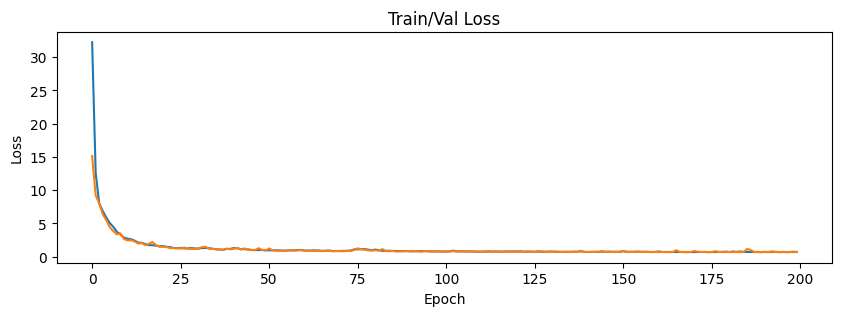

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3))

ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Val Loss")

ax.set_title("Train/Val Loss")

ax.set_xlabel("Epoch")

ax.set_ylabel("Loss")

Fixed example indices: [128, 155, 252, 145, 83, 59, 93, 277, 326, 220]
[loaded] checkpoints_Jan19/best.pt


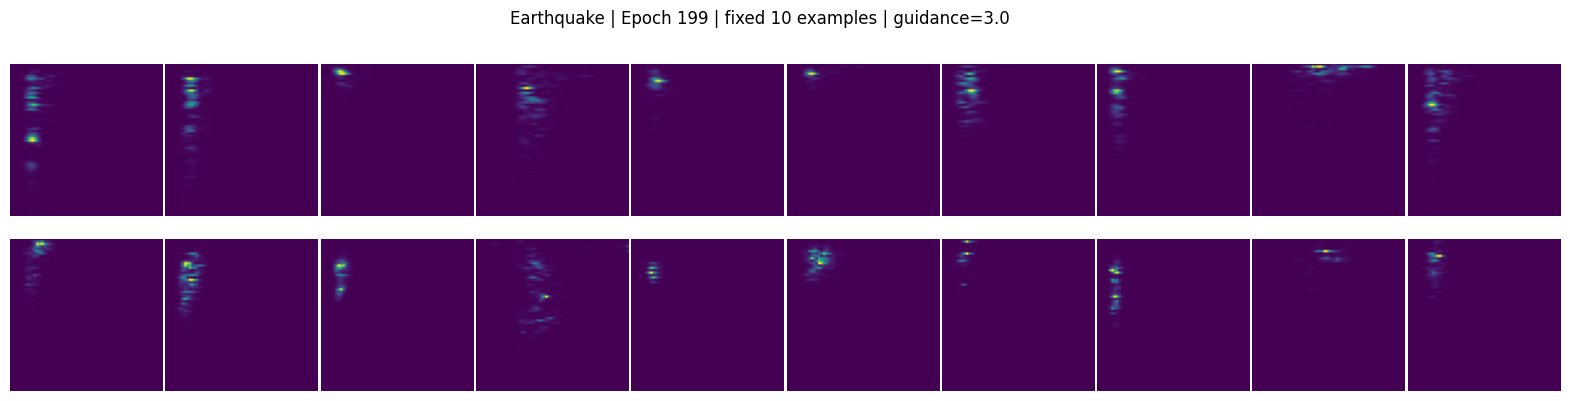

[saved] checkpoints_Jan19/viz_fixed10/earthquake_epoch199_fixed10.png


In [ ]:
epoch_to_plot = num_epochs-1
n_examples = 10
guidance_scale = 3.0
img_wh = (target_size, target_size)

viz_ds = test_ds
viz_dir = os.path.join(checkpoint_dir, "viz_fixed10")
os.makedirs(viz_dir, exist_ok=True)

fixed_seed = 666
gen_seed_base = 666

g = torch.Generator().manual_seed(fixed_seed)
perm = torch.randperm(len(viz_ds), generator=g)
pick_idx = perm[:n_examples].tolist()
print("Fixed example indices:", pick_idx)

def denorm_img(dataset, y_log_bchw):
    mag = (10 ** y_log_bchw) - 1e-8
    return mag.clamp(min=0).detach().cpu()

def denorm_c(dataset, c_norm):
    c_den = c_norm * (dataset.x_std.cpu() + 10 ** (-8)) + dataset.x_mean.cpu()
    return c_den

ckpt_path = os.path.join(checkpoint_dir, f"best.pt")
# if not os.path.exists(ckpt_path):
#     raise FileNotFoundError(f"checkpoint not found: {ckpt_path}")

# model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()
print(f"[loaded] {ckpt_path}")

fig, ax = plt.subplots(
    nrows=2, ncols=n_examples,
    figsize=(2.0 * n_examples, 4.5),
    gridspec_kw={'wspace': 0.02, 'hspace': 0.02}
)

for col, ds_i in enumerate(pick_idx):
    c_norm, y_norm = viz_ds[ds_i]
    c = c_norm.unsqueeze(0).to(device)
    y = y_norm.unsqueeze(0).to(device)

    x_gen_norm, _ = model.sample(
        c, img_wh=img_wh, guidance_scale=guidance_scale, seed=gen_seed_base + col
    )

    y_den = denorm_img(dataset, y)[0, 0].detach().cpu()
    x_den = denorm_img(dataset, x_gen_norm)[0, 0].detach().cpu()

    y_den = torch.clamp(y_den, min=0)
    x_den = torch.clamp(x_den, min=0)

    vmin = min(y_den.min().item(), x_den.min().item())
    vmax = max(y_den.max().item(), x_den.max().item())

    ax[0, col].imshow(y_den, vmin=vmin, vmax=vmax)
    ax[0, col].axis("off")

    ax[1, col].imshow(x_den, vmin=vmin, vmax=vmax)
    ax[1, col].axis("off")

    ax[0, col].imshow(y_den)
    ax[0, col].axis("off")

    ax[1, col].imshow(x_den)
    ax[1, col].axis("off")

    # M_val, R_val, VS_val = denorm_c(dataset, c_norm).tolist()
    # ax[0, col].set_title(f"M={M_val:.2f}\nR={R_val:.2f}\nVS30={VS_val:.0f}", fontsize=8)

ax[0, 0].set_ylabel("GT", fontsize=10)
ax[1, 0].set_ylabel("Gen", fontsize=10)
fig.suptitle(
    f"Earthquake | Epoch {epoch_to_plot} | fixed 10 examples | guidance={guidance_scale}",
    fontsize=12
)

out_png = os.path.join(viz_dir, f"earthquake_epoch{epoch_to_plot}_fixed10.png")
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {out_png}")